In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()

In [3]:
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_PATH='drive/MyDrive/MAD/'
df = pd.read_csv(data_PATH+'Salary_Data.csv')
df.head()

,YearsExperience,Salary
0,1.1,39343.0
1,1.3,46205.0
2,1.5,37731.0
3,2.0,43525.0
4,2.2,39891.0


Проверка типов данных и пропущенных значений

In [6]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearsExperience  30 non-null     float64
 1   Salary           30 non-null     float64
dtypes: float64(2)
memory usage: 612.0 bytes


,0
YearsExperience,0
Salary,0


Проверка выбросов с помощью метода IQR

In [7]:
for column in ['YearsExperience', 'Salary']:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    print(f'Выбросы в {column}: {outliers}')

Выбросы в YearsExperience: Series([], Name: YearsExperience, dtype: float64)
Выбросы в Salary: Series([], Name: Salary, dtype: float64)


Вывод: Датасет чистый, без пропусков и выбросов. Категориальных признаков нет.

## 2. Визуализация исходных данных
  Scatter plot: зависимость Salary от YearsExperience

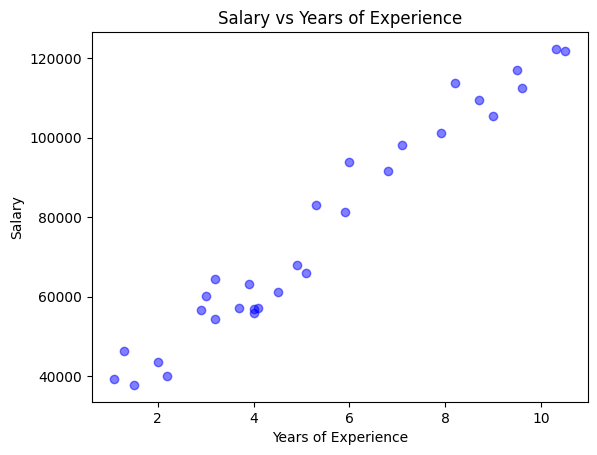

In [8]:
plt.scatter(df['YearsExperience'], df['Salary'], color='blue', alpha=0.5)
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.title('Salary vs Years of Experience')
plt.show()

Boxplot для выявления выбросов

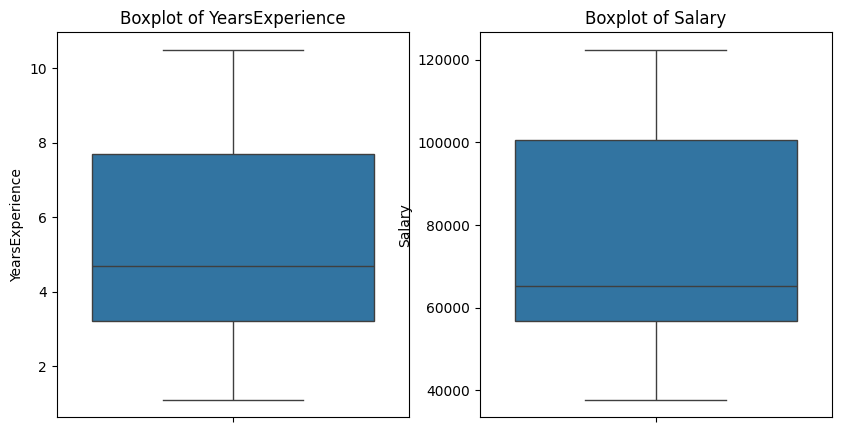

In [10]:
import seaborn as sns
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['YearsExperience'])
plt.title('Boxplot of YearsExperience')
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Salary'])
plt.title('Boxplot of Salary')
plt.show()

Гистограммы распределения

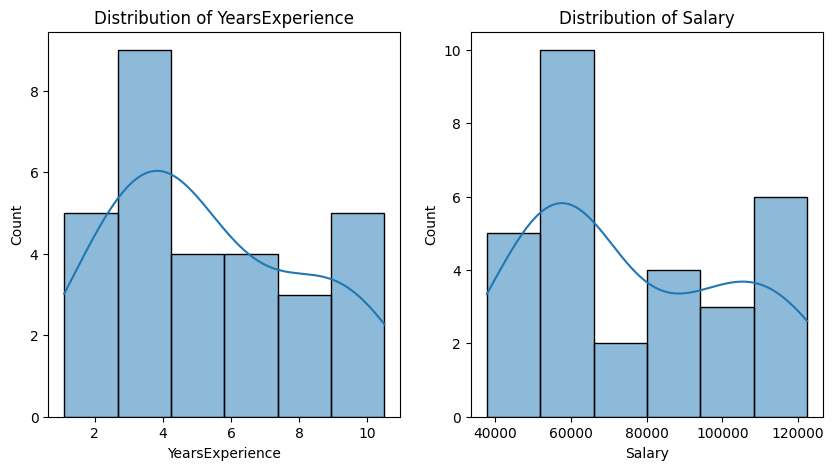

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['YearsExperience'], kde=True)
plt.title('Distribution of YearsExperience')
plt.subplot(1, 2, 2)
sns.histplot(df['Salary'], kde=True)
plt.title('Distribution of Salary')
plt.show()

Вывод: Видна линейная зависимость. Salary имеет правую асимметрию.

## 3. Дескриптивная статистика

In [12]:
df.describe()

,YearsExperience,Salary
count,30.000000,30.000000
mean,5.313333,76003.000000
std,2.837888,27414.429785
min,1.100000,37731.000000
25%,3.200000,56720.750000
50%,4.700000,65237.000000
75%,7.700000,100544.750000
max,10.500000,122391.000000


## 4. Исследование закона распределения
Тест Шапиро-Уилка на нормальность

In [14]:
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

In [15]:
for column in ['YearsExperience', 'Salary']:
    stat, p = stats.shapiro(df[column])
    print(f'Шапиро-Уилк для {column}: статистика={stat:.4f}, p-value={p:.4f}')
    if p > 0.05:
        print(f'{column} нормально распределено')
    else:
        print(f'{column} не нормально распределено')

Шапиро-Уилк для YearsExperience: статистика=0.9421, p-value=0.1034
YearsExperience нормально распределено
Шапиро-Уилк для Salary: статистика=0.9103, p-value=0.0152
Salary не нормально распределено


Логарифмирование Salary для приближения к нормальному распределению

In [16]:
df['LogSalary'] = np.log1p(df['Salary'])
stat, p = stats.shapiro(df['LogSalary'])
print(f'Шапиро-Уилк для LogSalary: статистика={stat:.4f}, p-value={p:.4f}')
if p > 0.05:
    print('LogSalary нормально распределено')
else:
    print('LogSalary не нормально распределено')

Шапиро-Уилк для LogSalary: статистика=0.9316, p-value=0.0541
LogSalary нормально распределено


Гистограмма LogSalary

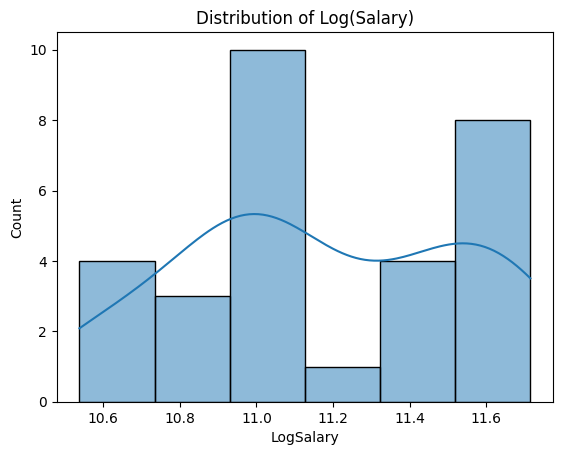

In [17]:
sns.histplot(df['LogSalary'], kde=True)
plt.title('Distribution of Log(Salary)')
plt.show()

Вывод: Salary не нормальное, LogSalary ближе к нормальному распределению.

## 5. Выявление статистически аномальных значений
 Уже выполнено в пункте 1: выбросов нет.

# Часть 2: Регрессионный анализ
## 6. Корреляционный анализ
 Корреляция между YearsExperience и Salary

In [20]:
print(df[['YearsExperience', 'Salary']].corr())
print(df[['YearsExperience', 'LogSalary']].corr())

                 YearsExperience    Salary
YearsExperience         1.000000  0.978242
Salary                  0.978242  1.000000
                 YearsExperience  LogSalary
YearsExperience         1.000000   0.965385
LogSalary               0.965385   1.000000


## 7. Построение регрессионной модели
 Подготовка данных

In [21]:
X = df[['YearsExperience']].values
y = df['Salary'].values
y_log = df['LogSalary'].values

Модель 1: Линейная регрессия (Salary)

In [22]:
model1 = LinearRegression()
model1.fit(X, y)
y_pred1 = model1.predict(X)
print('Модель 1: Salary ~ YearsExperience')
print(f'Intercept (beta_0): {model1.intercept_}')
print(f'Coefficient (beta_1): {model1.coef_[0]}')

Модель 1: Salary ~ YearsExperience
Intercept (beta_0): 25792.200198668696
Coefficient (beta_1): 9449.962321455076


 Модель 2: Линейная регрессия (LogSalary)

In [23]:
model2 = LinearRegression()
model2.fit(X, y_log)
y_pred2 = model2.predict(X)
print('\nМодель 2: LogSalary ~ YearsExperience')
print(f'Intercept (beta_0): {model2.intercept_}')
print(f'Coefficient (beta_1): {model2.coef_[0]}')


Модель 2: LogSalary ~ YearsExperience
Intercept (beta_0): 10.507426437540962
Coefficient (beta_1): 0.12545108994006113


Модель 3: Полиномиальная регрессия (Salary)

In [24]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
model3 = LinearRegression()
model3.fit(X_poly, y)
y_pred3 = model3.predict(X_poly)
print('\nМодель 3: Salary ~ YearsExperience + YearsExperience^2')
print(f'Intercept (beta_0): {model3.intercept_}')
print(f'Coefficients (beta_1, beta_2): {model3.coef_[1:]}')


Модель 3: Salary ~ YearsExperience + YearsExperience^2
Intercept (beta_0): 26214.932677059573
Coefficients (beta_1, beta_2): [9259.2838882    16.39256632]


## 8. Статистический анализ регрессионной модели (Модель 2)
Оценка ошибок

In [25]:
y_pred2_original = np.expm1(y_pred2)
y_original = np.expm1(y_log)
mse_original = mean_squared_error(y_original, y_pred2_original)
rmse_original = np.sqrt(mse_original)
mae_original = mean_absolute_error(y_original, y_pred2_original)
r2_original = r2_score(y_original, y_pred2_original)
print('Метрики Модели 2 в исходном масштабе:')
print(f'MSE: {mse_original}')
print(f'RMSE: {rmse_original}')
print(f'MAE: {mae_original}')
print(f'R²: {r2_original}')

Метрики Модели 2 в исходном масштабе:
MSE: 52030069.590015806
RMSE: 7213.187200538733
MAE: 5900.713289811628
R²: 0.9283824880071058


Анализ остатков и нормальность остатков

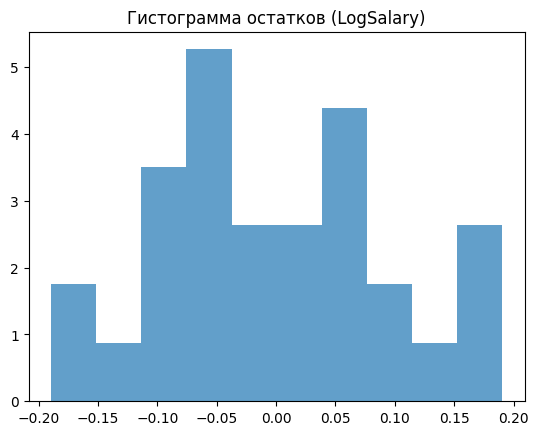

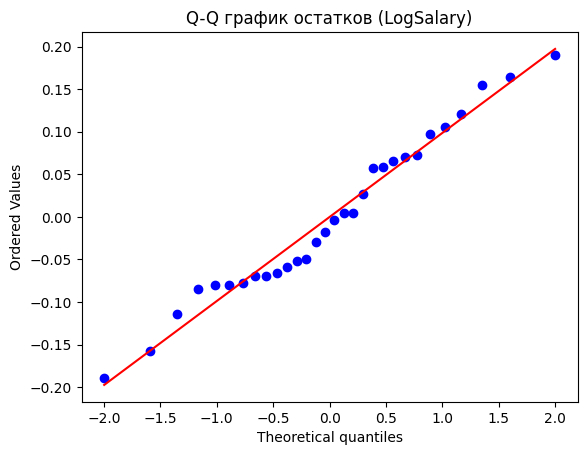

Шапиро-Уилк: статистика=0.9702, p-value=0.5446


In [27]:
residuals = y_log - y_pred2

plt.hist(residuals, bins=10, density=True, alpha=0.7)
plt.title('Гистограмма остатков (LogSalary)')
plt.show()

stats.probplot(residuals, dist='norm', plot=plt)
plt.title('Q-Q график остатков (LogSalary)')
plt.show()

shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f'Шапиро-Уилк: статистика={shapiro_stat:.4f}, p-value={shapiro_p:.4f}')

Проверка среднего остатков

In [28]:
t_stat, p_value = stats.ttest_1samp(residuals, popmean=0)
print(f'\nСреднее остатков: {np.mean(residuals):.4f}')
print(f't-тест: статистика={t_stat:.4f}, p-value={p_value:.4f}')


Среднее остатков: -0.0000
t-тест: статистика=-0.0000, p-value=1.0000


Адекватность модели


Statsmodels summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     383.6
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           7.03e-18
Time:                        17:31:51   Log-Likelihood:                 28.184
No. Observations:                  30   AIC:                            -52.37
Df Residuals:                      28   BIC:                            -49.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5074      0.0

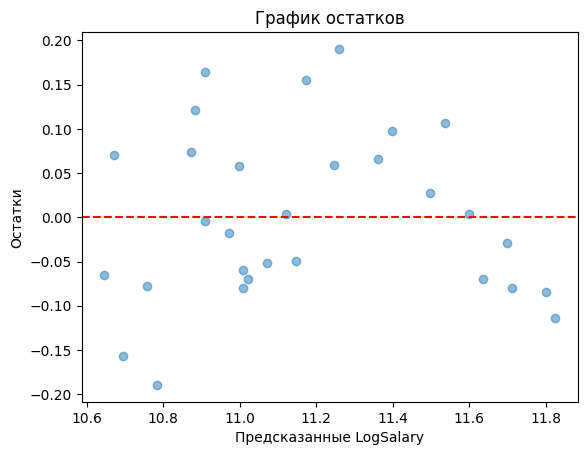

In [29]:
X_with_const = sm.add_constant(X)
model_sm = sm.OLS(y_log, X_with_const).fit()
print('\nStatsmodels summary:')
print(model_sm.summary())

plt.scatter(y_pred2, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные LogSalary')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.show()

Автокорреляция

In [30]:
dw_stat = durbin_watson(residuals)
print(f'\nСтатистика Дарбина-Уотсона: {dw_stat:.4f}')
if 1.5 <= dw_stat <= 2.5:
    print('Автокорреляция отсутствует')
elif dw_stat < 1.5:
    print('Положительная автокорреляция')
else:
    print('Отрицательная автокорреляция')


Статистика Дарбина-Уотсона: 1.4378
Положительная автокорреляция


Гетероскедастичность

In [31]:
bp_test = het_breuschpagan(residuals, X_with_const)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print('\nТест Бройша-Пагана:')
for label, value in zip(labels, bp_test):
    print(f'{label}: {value:.4f}')
if bp_test[1] > 0.05:
    print('Гетероскедастичность отсутствует')
else:
    print('Гетероскедастичность присутствует')


Тест Бройша-Пагана:
LM Statistic: 1.0437
LM-Test p-value: 0.3070
F-Statistic: 1.0093
F-Test p-value: 0.3237
Гетероскедастичность отсутствует


## 9. Сравнительный анализ моделей

In [32]:
print('Модель 1 (Salary):')
print(f'MSE: {mean_squared_error(y, y_pred1)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y, y_pred1))}')
print(f'MAE: {mean_absolute_error(y, y_pred1)}')
print(f'R²: {r2_score(y, y_pred1)}')

print('\nМодель 2 (LogSalary, в исходном масштабе):')
print(f'MSE: {mse_original}')
print(f'RMSE: {rmse_original}')
print(f'MAE: {mae_original}')
print(f'R²: {r2_score(y_original, y_pred2_original)}')

print('\nМодель 3 (Полиномиальная):')
print(f'MSE: {mean_squared_error(y, y_pred3)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y, y_pred3))}')
print(f'MAE: {mean_absolute_error(y, y_pred3)}')
print(f'R²: {r2_score(y, y_pred3)}')

Модель 1 (Salary):
MSE: 31270951.722280964
RMSE: 5592.043608760661
MAE: 4644.2012894435375
R²: 0.9569566641435086

Модель 2 (LogSalary, в исходном масштабе):
MSE: 52030069.590015806
RMSE: 7213.187200538733
MAE: 5900.713289811628
R²: 0.9283824880071058

Модель 3 (Полиномиальная):
MSE: 31257508.45094721
RMSE: 5590.841479683288
MAE: 4653.069044746811
R²: 0.956975168321065


Вывод: Модель 2 (LogSalary) предпочтительнее

## 10. Прогнозирование и оценка качества
Разделение на обучающую и тестовую выборки

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

Обучение Модели 2

In [34]:
model2.fit(X_train, y_train)
y_test_pred = model2.predict(X_test)

Оценка на тестовом наборе

In [35]:
y_test_original = np.expm1(y_test)
y_test_pred_original = np.expm1(y_test_pred)
print('Метрики на тестовой выборке:')
print(f'MSE: {mean_squared_error(y_test_original, y_test_pred_original)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))}')
print(f'MAE: {mean_absolute_error(y_test_original, y_test_pred_original)}')
print(f'R²: {r2_score(y_test_original, y_test_pred_original)}')

Метрики на тестовой выборке:
MSE: 84931050.7228127
RMSE: 9215.804399118544
MAE: 7645.561789426755
R²: 0.8337280242928226


Прогноз для нового объекта (8 лет опыта)

In [37]:
new_data = np.array([[8.0]])
new_pred_log = model2.predict(new_data)
new_pred = np.expm1(new_pred_log)
print(f'\nПрогноз зарплаты для 8 лет опыта: {new_pred[0]:.2f}')


Прогноз зарплаты для 8 лет опыта: 98876.35
